In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
import scanpy as sc
import anndata
import pandas as pd
import tools
import logging
import mira
import warnings

warnings.filterwarnings('ignore')

/home/haiyi/anaconda3/envs/halo2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## model setup
atac_model = mira.topics.AccessibilityTopicModel(counts_layer='counts',
                                                 dataset_loader_workers = 3)

rna_model = mira.topics.ExpressionTopicModel(
    endogenous_key='endog',
    exogenous_key='endog',
    counts_layer='counts',
    seed = 0,
    hidden=64, # to make the tutorial faster. In practice, use the default of 128!
)          


rna_model = mira.topics.ExpressionTopicModel.load('MIRA/hair_rna_topic_model.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('MIRA/hair_atac_topic_model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [3]:
## loading the data
# rna_data = anndata.read_h5ad("data/datasets/mouse_hair_rna_interim.h5ad")
# atac_data =  anndata.read_h5ad("data/datasets/mouse_hair_atac_interim.h5ad")

rna_data = sc.read_h5ad("data/datasets/mouse_hair_mira_rna.h5ad")
atac_data = sc.read_h5ad("data/datasets/mouse_hair_mira_atac.h5ad")

In [14]:
atac_model.predict(atac_data)
rna_model.predict(rna_data)

Predicting latent vars: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]
INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
Predicting latent vars: 100%|██████████| 13/13 [00:01<00:00, 10.66it/s]
INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.t

In [15]:
atac_data

AnnData object with n_obs × n_vars = 6436 × 112656
    obs: 'atac.bc', 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8'
    var: 'feature_types', 'modality', 'n_cells', 'chr', 'start', 'end'
    uns: 'TSS_metadata', 'distance_to_TSS_genes', 'motifs', 'topic_dendogram'
    obsm: 'X_topic_compositions'
    varm: 'distance_to_TSS', 'motifs_hits', 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'counts'

In [12]:
rna_data.write_h5ad("data/datasets/mouse_hair_mira_rna.h5ad")
atac_data.write_h5ad("data/datasets/mouse_hair_mira_atac.h5ad")

In [14]:
adata_mvi = sc.read_h5ad("data/datasets/mouse_hair_multi_omics.h5ad")


(6436, 6)
(6436, 6)
6
6


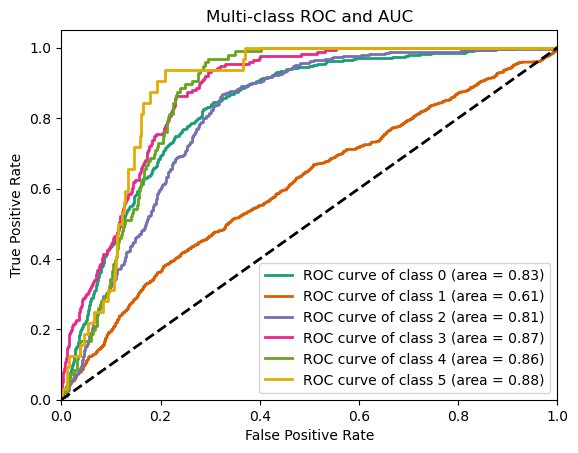

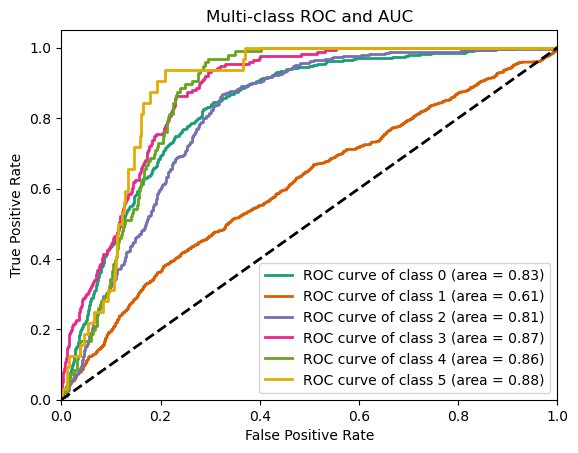

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

rna_feature = rna_data.obs[[ 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']]
atac_feature=  atac_data.obs[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']]
print(rna_feature.shape)
print(atac_feature.shape)

# X = pd.concat([atac_feature, rna_feature],axis=1)
X = pd.concat([rna_feature],axis=1)
bins = 6
y = pd.cut(adata_mvi.obs['latent_time'], bins, labels=[i for i in range(bins)])
y = label_binarize(y, classes=range(bins))
n_classes = y.shape[1]
print(n_classes)
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=0) 

#instantiate the model
classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
classifier.fit(X_train, y_train)

#fit the model using the training data
y_score = classifier.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = sns.color_palette("Dark2")
# colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
plt.savefig("figs/Hair/20_aligned/mira_roc.pdf", dpi=300)
bins = 6
y = pd.cut(adata_mvi.obs['latent_time'], bins, labels=[i for i in range(bins)])
y = label_binarize(y, classes=range(bins))
n_classes = y.shape[1]
print(n_classes)
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=0) 

#instantiate the model
classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
classifier.fit(X_train, y_train)

#fit the model using the training data
y_score = classifier.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = sns.color_palette("Dark2")
# colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
# plt.savefig("figs/Hair/20_aligned/mira_roc.pdf", dpi=300)
plt.savefig("figs/Hair/20_aligned/mira_rna_roc.pdf", dpi=300)
roc_df_temp = pd.DataFrame({"fpr":fpr, "tpr": tpr, "roc_auc":roc_auc, "methods": "mira"})


In [37]:
roc_df_temp.to_csv("hair_mira_roc.csv")

In [27]:
rna_data

AnnData object with n_obs × n_vars = 6436 × 959
    obs: 'atac.bc', 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'model_read_scale', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13'
    var: 'feature_types', 'modality', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'hvg', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_topic_compositions', 'X_umap'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'counts'
    obsp:

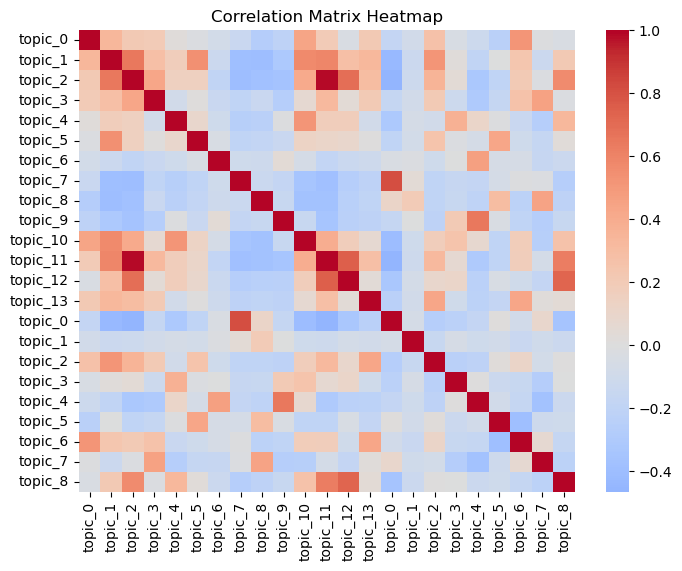

In [28]:
import seaborn as sns
rna_feature = rna_data.obs[[ 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13']]
atac_feature=  atac_data.obs[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8']]
df_A = pd.DataFrame(rna_feature)
df_B = pd.DataFrame(atac_feature)
df_combined = pd.concat([df_A, df_B], axis=1)
correlation_matrix = df_combined.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", center=0.0)
plt.title('Correlation Matrix Heatmap')
plt.show()

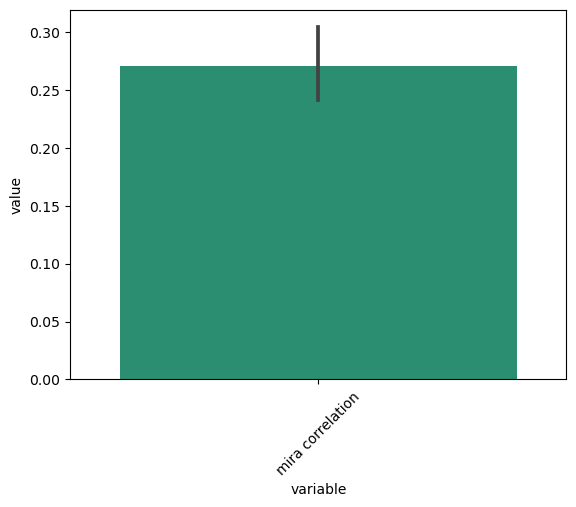

In [35]:
lower_triangular_matrix = np.tril(np.abs(correlation_matrix), k=-1)
lower_diagonal_values = lower_triangular_matrix[lower_triangular_matrix != 0]
df = pd.DataFrame({"variable": "mira correlation", "value": lower_diagonal_values})
ax = sns.barplot(x='variable', y='value', data=df, palette="Dark2")
plt.xticks(rotation=45)
plt.savefig("corr_mira_hair.pdf", dpi=300)

In [33]:
df.to_csv("hair_corr_mira.csv")

In [27]:
rna_data.write_h5ad("data/datasets/mouse_hair_mira_rna.h5ad")
atac_data.write_h5ad("data/datasets/mouse_hair_mira_atac.h5ad")


In [3]:
rna_data = sc.read_h5ad("data/datasets/mouse_hair_mira_rna.h5ad")
atac_data = sc.read_h5ad("data/datasets/mouse_hair_mira_atac.h5ad")

In [85]:
rna_data

AnnData object with n_obs × n_vars = 6436 × 959
    obs: 'atac.bc', 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'model_read_scale', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'latent_time_cat', 'latent_time_2', 'latent_time_10', 'latent_time_3', 'latent_time_8', 'latent_time_6', 'local_peaks', 'temp_gene'
    var: 'feature_types', 'modality', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'hvg', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm

In [34]:
mira.datasets.mm10_chrom_sizes()
mira.datasets.mm10_tss_data()

INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/mm10.chrom.sizes
INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/mm10_tss_data.bed12


In [38]:
## ATAC data get TSS annotation

mira.tl.get_distance_to_TSS(atac_data,
                            tss_data='mira-datasets/mm10_tss_data.bed12',
                            genome_file='mira-datasets/mm10.chrom.sizes')

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


In [23]:
atac_data.write_h5ad("data/datasets/mouse_hair_mira_atac.h5ad")

In [5]:
del rna_data.obsm["X_topic_compositions"]

In [48]:
rna_data.var.index = rna_data.var.index.str.upper()
rp_args = dict(expr_adata = rna_data, atac_adata= atac_data)
rp_genes = list(rna_model.features[rna_model.highly_variable])
rp_genes = [str(e).upper() for e in rp_genes]
lgenes = ['Gna12', 'Dmpk', 'Ubtf', 'Nfe2l3', 'Cspp1', 'Wdr47', 'Ptpra', 'Mfsd2a',
       'Nedd9', 'Lrp4', 'Myo9a', 'Tfap2b', 'Zfand5', 'Hs3st3b1', 'Orc1',
       'Inpp5f', 'Lama5', 'Akap10', 'Mylk', 'Heg1', 'Agl', 'Safb2', 'Brd9',
       'Rnf180', 'Itgb5', 'Bmp2k', 'Fnbp1l', 'Cpt1a', 'Ccnt1', 'Slc7a6'] + ['Mt2', 'Krt23', 'Braf', 'Slc4a7', 'Lonrf3', 'Fam126b', 'Gpatch1',
       'Sdf4', 'Cers4', 'R3hdm2', 'Nbea', 'Rnf10', 'Ppp1r14c', 'Kremen1',
       'Nav2', '5031439G07Rik', 'Ythdf1', 'Galnt3', 'Setd7', 'Spata5',
       'Arhgef10l', 'Cep128', 'Ltbp3', 'Ranbp1', 'Atg7', 'Tcf3', 'Ddx52',
       'BC005561', 'Psrc1', 'Chd3']
irs_genes = ["CALM2", "CTSB", "GATA3", "WNT3"]       
lgenes = [str(e).upper() for e in lgenes]

rp_genes = rp_genes + lgenes +irs_genes
# rp_genes=["Chd3"]

In [49]:
litemodel = mira.rp.LITE_Model(expr_model = rna_model,
                              accessibility_model=atac_model,
                              counts_layer='counts',
                              genes = rp_genes)

In [6]:
litemodel.fit(**rp_args, n_workers=4,
              callback = mira.rp.SaveCallback("rpmodels/hair/"))

In [50]:
litemodel.load("rpmodels/hair/")

In [22]:
rna_data.var.index = rna_data.var.index.str.upper()
rna_data.obs["latent_time_cat"] = pd.cut(rna_data.obs['latent_time'], 20, labels=[str(i) for i in range(20)])
rna_data.obs["latent_time_2"] = pd.cut(rna_data.obs['latent_time'], 50, labels=[str(i) for i in range(50)])
rna_data.obs["latent_time_10"] = pd.cut(rna_data.obs['latent_time'], 10, labels=[str(i) for i in range(10)])
rna_data.obs["latent_time_3"] = pd.cut(rna_data.obs['latent_time'], 5, labels=[str(i) for i in range(5)])
rna_data.obs["latent_time_8"] = pd.cut(rna_data.obs['latent_time'], 8, labels=[str(i) for i in range(8)])
rna_data.obs["latent_time_6"] = pd.cut(rna_data.obs['latent_time'], 6, labels=[str(i) for i in range(6)])

In [9]:
### Plot local genes and local peaks
from scipy.sparse import csr_matrix
from scipy.sparse import diags


def tfidf_norm(adata_atac, scale_factor=1e4):
    """TF-IDF normalization.
    This function normalizes counts in an AnnData object with TF-IDF.
    Parameters
    ----------
    adata_atac: :class:`~anndata.AnnData`
        ATAC anndata object.
    scale_factor: `float` (default: 1e4)
        Value to be multiplied after normalization.
    copy: `bool` (default: `False`)
        Whether to return a copy or modify `.X` directly.
    Returns
    -------
    If `copy==True`, a new ATAC anndata object which stores normalized counts in `.X`.
    """
    npeaks = adata_atac.X.sum(1)
    npeaks_inv = csr_matrix(1.0/npeaks)
    tf = adata_atac.X.multiply(npeaks_inv)
    idf = diags(np.ravel(adata_atac.X.shape[0] / adata_atac.X.sum(0))).log1p()
    new_X = tf.dot(idf) * scale_factor
    return new_X


In [9]:
## add normalized layers 
rna_norm = sc.read_h5ad("data/datasets/mouse_hair_mira_rna_norm.h5ad")
atac_norm = sc.read_h5ad("data/datasets/mouse_hair_mira_atac_norm.h5ad")

In [4]:
rna_norm = sc.read_h5ad("data/datasets/mouse_hair_mira_rna_norm.h5ad")
atac_norm = sc.read_h5ad("data/datasets/mouse_hair_mira_atac_norm.h5ad")


In [5]:
rna_data.layers["norm"] = rna_norm.layers["norm"] 
atac_data.layers["norm"] = atac_norm.layers["norm"]

In [20]:
atac_data.obs

,atac.bc,celltype,latent_time,batch_id,modality,_scvi_batch,_scvi_labels,epxr_latent_0,epxr_latent_1,epxr_latent_2,...,atac_latent_9,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0_paired,"R1.01,R2.06,R3.83,P1.07",TAC-1,0.366586,1,paired,0,0,-0.329691,0.349999,-0.094741,...,0.859182,0.004662,0.000239,0.073431,0.162936,0.266621,0.017314,0.093287,0.007105,0.374404
1_paired,"R1.01,R2.11,R3.86,P1.08",TAC-1,0.387718,1,paired,0,0,-0.209401,1.059089,0.475534,...,0.711788,0.003608,0.000041,0.029041,0.317111,0.308148,0.011192,0.092211,0.002834,0.235814
2_paired,"R1.01,R2.15,R3.09,P1.07",TAC-1,0.147633,1,paired,0,0,-0.547288,-0.103089,0.148641,...,-0.069991,0.033094,0.000229,0.526569,0.072198,0.125511,0.160533,0.040806,0.010435,0.030625
3_paired,"R1.01,R2.17,R3.81,P1.05",TAC-1,0.356577,1,paired,0,0,-0.258864,-0.088589,-1.091653,...,1.654312,0.008312,0.000289,0.012934,0.472446,0.225037,0.010972,0.118562,0.004911,0.146537
4_paired,"R1.01,R2.18,R3.95,P1.06",TAC-1,0.131708,1,paired,0,0,0.651902,0.508803,-0.290743,...,-0.784071,0.001895,0.000114,0.226512,0.073615,0.039660,0.028004,0.054866,0.024150,0.551183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6431_paired,"R1.96,R2.73,R3.72,P1.08",Hair Shaft-cuticle.cortex,0.345225,1,paired,0,0,0.450251,0.547970,-0.263151,...,0.169781,0.032046,0.333727,0.073395,0.045990,0.316157,0.060627,0.034980,0.016090,0.086987
6432_paired,"R1.96,R2.82,R3.52,P1.07",Hair Shaft-cuticle.cortex,0.313259,1,paired,0,0,0.781673,-0.192597,0.503431,...,0.569222,0.696354,0.005203,0.026700,0.005115,0.102743,0.026570,0.086791,0.047089,0.003435
6433_paired,"R1.96,R2.83,R3.68,P1.06",Hair Shaft-cuticle.cortex,0.343906,1,paired,0,0,-0.965674,0.367740,-0.886593,...,-1.245537,0.244577,0.000863,0.214190,0.022448,0.054060,0.364378,0.022014,0.063336,0.014134
6434_paired,"R1.96,R2.87,R3.63,P1.07",Hair Shaft-cuticle.cortex,0.475595,1,paired,0,0,1.658696,-1.205393,0.108684,...,1.073898,0.905075,0.010709,0.003398,0.000796,0.014219,0.030873,0.006405,0.028133,0.000392


In [12]:
atac_data.layers["norm"][:,1]

array([2.0316339, 2.0022717, 1.3739473, ..., 1.2509259, 1.8704894,
       1.9182318], dtype=float32)

In [7]:
norm_X = atac_norm.layers["norm"]
# norm_X = tfidf_norm(atac_data)

In [6]:
def aggregate_local_atac(table, norm_X, atac_data):
    indices = table.index.to_numpy()
    col_index = [atac_data.var.index.get_loc(e) for e in indices]
    gene_peaks = norm_X[:, col_index]
    gene_peaks = np.sum(gene_peaks, axis=1)
    # print(gene_peaks)
    
    return gene_peaks

def get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X):
    table = litemodel[genename].get_influential_local_peaks(atac_data, decay_periods = .8)
    peaks = aggregate_local_atac(table, norm_X,atac_data)
    rna_data.obs["local_peaks"] = peaks

def get_gene_local_atac_mtx(genenames, litemodel, rna_data, atac_data, norm_X):
    for genename in genenames:
        table = litemodel[genename].get_influential_local_peaks(atac_data, decay_periods = .8)
        peaks = aggregate_local_atac(table, norm_X)
        name = genename+"local_peaks"
        rna_data.obs[name] = peaks


In [8]:
from scipy.sparse import csr_matrix
def get_peaks(rna_data, atac_data, litemodel, decay_periods=.8):
    norm_X = atac_data.layers["norm"]
    cellnum =rna_data.shape[0]
    genenames = rna_data.var.index.tolist()
    peaks = []
    for gene in genenames:
        try:
            table = litemodel[gene].get_influential_local_peaks(atac_data, decay_periods = decay_periods)
            peak = aggregate_local_atac(table, norm_X, atac_data)
        except:
            peak = [0]*cellnum
        peaks.append(peak)
        # print(len(peaks))
    peaks  = np.array(peaks).transpose()
    peaks = csr_matrix(peaks)
    rna_data.layers["peaks"] = peaks    

In [22]:
rna_data.layers["peaks"]

<6436x959 sparse matrix of type '<class 'numpy.float32'>'
	with 6159252 stored elements in Compressed Sparse Row format>

In [15]:
get_peaks(rna_data, atac_data, litemodel)

In [33]:
atac_data

AnnData object with n_obs × n_vars = 6436 × 112656
    obs: 'atac.bc', 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8'
    var: 'feature_types', 'modality', 'n_cells', 'chr', 'start', 'end'
    uns: 'TSS_metadata', 'distance_to_TSS_genes', 'motifs', 'topic_dendogram'
    obsm: 'X_topic_compositions'
    varm: 'distance_to_TSS', 'motifs_hits', 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'counts', 'norm'

In [22]:
rna_data.write_h5ad("data/datasets/mouse_hair_rna_paired4.h5ad")

In [24]:
cols = ['epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6',
 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'atac_latent_0', 'atac_latent_1', 
'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9',]
rna_data.obs = rna_data.obs.drop(cols, axis=1)
rna_data

AnnData object with n_obs × n_vars = 6436 × 959
    obs: 'atac.bc', 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'model_read_scale', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'latent_time_cat', 'latent_time_2', 'latent_time_10', 'latent_time_3', 'latent_time_8', 'latent_time_6'
    var: 'feature_types', 'modality', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'hvg', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_topic_compositions', 'X_umap'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'counts', 'norm'
    obsp: 'connectivities', 'distances'

In [9]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def get_norm_gene_local(genename,time):
    peak_mean = rna_data.obs.groupby(time)["local_peaks"].mean()
    rna_data.obs["temp_gene"] =  rna_data[:,[genename.capitalize()]].X.toarray()
    gene_mean = rna_data.obs.groupby(time)["temp_gene"].mean()
    timelist = rna_data.obs.time.unique().tolist()
    genesplie = make_interp_spline(np.array(timelist), gene_mean.value)

    df = pd.DataFrame([peak_mean, gene_mean, genesplie]).T
    df = df.reset_index()
    fig, ax = plt.subplots()
    df.plot(x=time, y = "local_peaks", ax=ax)
    df.plot(x=time, y = "temp_gene", ax=ax,secondary_y=True, color="r")



In [35]:
get_peaks(rna_data,atac_data, litemodel, decay_periods=8.)
rna_data

(6436, 959)


AnnData object with n_obs × n_vars = 6436 × 959
    obs: 'atac.bc', 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'model_read_scale', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'latent_time_cat', 'latent_time_2', 'latent_time_10', 'latent_time_3', 'latent_time_8', 'latent_time_6'
    var: 'feature_types', 'modality', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'hvg', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_topic_compositions', 'X_umap'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'counts', 'norm', 'peaks'
    obsp: 'connectivities', 'distances'

In [10]:
def smooth_gene_peaks_plot(genename,time, linewidth, points=1000, save=False, legend=True):
    peak_mean = rna_data.obs.groupby(time)["local_peaks"].mean()
    rna_data.obs["temp_gene"] =   rna_data[:,[genename.upper()]].X.toarray()
    gene_mean = rna_data.obs.groupby(time)["temp_gene"].mean()
    timelist = rna_data.obs[time].unique()
    timelist = timelist.astype(np.float64)
    timelist = sorted(timelist)
    genesplie = make_interp_spline(np.array(timelist), gene_mean.values)
    peaksplie = make_interp_spline(np.array(timelist), peak_mean.values)
    X_ = np.linspace(timelist[0], timelist[-1], points)
    smooth_gene = genesplie(X_)
    smooth_peaks = peaksplie(X_)
    df = pd.DataFrame(index=X_)
    df["smooth_gene"] = smooth_gene
    df["smooth_peaks"] = smooth_peaks
    df = df.reset_index() 
    fig, ax = plt.subplots()
    # ax.grid(True)
        
    df.plot(x="index", y = "smooth_peaks", ax=ax, linewidth=linewidth, legend=legend)
    df.plot(x="index", y = "smooth_gene", ax=ax,secondary_y=True, color="r", linewidth=linewidth, legend=legend)
    if save:
        fig.savefig(save)

In [11]:
## Causal Score function


from causal_utils import infer_nonsta_dir

def gene_level_casual(genename,time, litemodel,rna_data,atac_data, norm_X, width=0.1):
    get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X)
    # peak_mean = rna_data.obs.groupby(time)["local_peaks"].mean().values
    rna_data.obs["temp_gene"] =   rna_data[:,[genename.upper()]].X.toarray()
    peaks = rna_data.obs["local_peaks"]
    genes = rna_data.obs["temp_gene"]
    times = rna_data.obs[time]
    # print("peaks shap {}, genes {}, time {}".format(peaks.shape, genes.shape, times.shape))
    gene_mean = genes
    peak_mean = peaks
    timelist = times
    # gene_mean = rna_data.obs.groupby(time)["temp_gene"].mean().values
    gene_mean = np.expand_dims(gene_mean, axis=1)
    peak_mean = np.expand_dims(peak_mean, axis=1)
    # timelist = rna_data.obs[time].unique()
    timelist = timelist.astype(np.float64)
    timelist = sorted(timelist)
    timelist = np.expand_dims(timelist, axis=1)

    score_ar, _, _ = infer_nonsta_dir(peak_mean, gene_mean, timelist, width=0.1)
    score_ra, _, _ =infer_nonsta_dir(gene_mean, peak_mean, timelist, width=0.1)
    # score_ar = np.log(score_ar)
    # score_ra = np.log(score_ra)
    score = score_ar - score_ra

    return score, score_ar, score_ra



def gene_level_casual_nonzero(genename,time, litemodel,rna_data,atac_data, norm_X, width=0.1, thresh=0.001):
    get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X)
    # peak_mean = rna_data.obs.groupby(time)["local_peaks"].mean().values
    rna_data.obs["temp_gene"] =   rna_data[:,[genename.upper()]].X.toarray()
    peaks = rna_data.obs[rna_data.obs.local_peaks>0]['local_peaks']
    genes = rna_data.obs[rna_data.obs.local_peaks>0]["temp_gene"]
    times = rna_data.obs[rna_data.obs.local_peaks>0][time]
    gene_mean = genes
    peak_mean = peaks
    timelist = times
    # gene_mean = rna_data.obs.groupby(time)["temp_gene"].mean().values
    gene_mean = np.expand_dims(gene_mean, axis=1)
    peak_mean = np.expand_dims(peak_mean, axis=1)
    # timelist = rna_data.obs[time].unique()
    timelist = timelist.astype(np.float64)
    timelist = sorted(timelist)
    timelist = np.expand_dims(timelist, axis=1)

    score_ar, _, _ = infer_nonsta_dir(peak_mean, gene_mean, timelist, width=width)
    score_ra, _, _ =infer_nonsta_dir(gene_mean, peak_mean, timelist, width=width)
    # score_ar = np.log(score_ar)
    # score_ra = np.log(score_ra)
    # score = -(score_ar - score_ra)
    score = -(score_ar - score_ra)
    couple_score =  score_ar - score_ra - thresh

    return score, score_ar, score_ra, couple_score


In [62]:
def smooth_gene_peaks_plot(genename,time, linewidth, points=1000, save=False, legend=True):
    peak_mean = rna_data.obs.groupby(time)["local_peaks"].mean()
    rna_data.obs["temp_gene"] =   rna_data[:,[genename.upper()]].X.toarray()
    gene_mean = rna_data.obs.groupby(time)["temp_gene"].mean()
    timelist = rna_data.obs[time].unique()
    timelist = timelist.astype(np.float64)
    timelist = sorted(timelist)
    genesplie = make_interp_spline(np.array(timelist), gene_mean.values)
    peaksplie = make_interp_spline(np.array(timelist), peak_mean.values)
    X_ = np.linspace(timelist[0], timelist[-1], points)
    smooth_gene = genesplie(X_)
    smooth_peaks = peaksplie(X_)
    df = pd.DataFrame(index=X_)
    df["smooth_gene"] = smooth_gene
    df["smooth_peaks"] = smooth_peaks
    df = df.reset_index() 
    fig, ax = plt.subplots()
    # ax.grid(True)
        
    df.plot(x="index", y = "smooth_peaks", ax=ax, linewidth=linewidth, legend=legend)
    df.plot(x="index", y = "smooth_gene", ax=ax,secondary_y=True, color="r", linewidth=linewidth, legend=legend)
    if save:
        fig.savefig(save)



def smooth_gene_peaks_plot_interv(genename,time, rna_data, linewidth, points=1000, save=False, legend=True, ticks=True, gcolor="b", pcolor="r", shade=0.3, title=False, gquant=0.6, pquant=0.6):
    localpeaks ="local_peaks"
    peak_mean = rna_data.obs[rna_data.obs.local_peaks>0].groupby(time)["local_peaks"].median().fillna(0)
    peak_std =  rna_data.obs[rna_data.obs.local_peaks>0].groupby(time)["local_peaks"].std()
    peak_max = rna_data.obs[rna_data.obs.local_peaks>0].groupby(time)[localpeaks].quantile(pquant).fillna(0)
    peak_min = rna_data.obs[rna_data.obs.local_peaks>0].groupby(time)[localpeaks].quantile(1- pquant).fillna(0)
    localpeaks = "local_peaks"
    rna_data.obs["temp_gene"] =   rna_data[:,[genename]].X.toarray()
    gene_mean = rna_data.obs[rna_data.obs.temp_gene>0].groupby(time)["temp_gene"].median().fillna(0)
    gene_std = rna_data.obs.groupby(time)["temp_gene"].std()

    # gene_max = rna_data.obs.groupby(time).apply(lambda g: g[g.temp_gene > g.temp_gene.quantile(.2)]).temp_gene.to_frame().groupby(time).mean().temp_gene.to_numpy() 
    # gene_min = rna_data.obs.groupby(time).apply(lambda g: g[g.temp_gene <= g.temp_gene.quantile(.9)]).temp_gene.to_frame().groupby(time).mean().temp_gene.to_numpy()

    gene_max = rna_data.obs[rna_data.obs.temp_gene>0].groupby(time)['temp_gene'].quantile(gquant).fillna(0)
    gene_min = rna_data.obs[rna_data.obs.temp_gene>0].groupby(time)['temp_gene'].quantile(1 - gquant).fillna(0)


    timelist = rna_data.obs[time].unique()
    timelist = timelist.astype(np.float64)
    timelist = sorted(timelist)

    genesplie = make_interp_spline(np.array(timelist), gene_mean.values)
    peaksplie = make_interp_spline(np.array(timelist), peak_mean.values)
    X_ = np.linspace(timelist[0], timelist[-1], points)
    smooth_gene = genesplie(X_)
    smooth_peaks = peaksplie(X_)



    genesplie_max = make_interp_spline(np.array(timelist), gene_max)
    peaksplie_max = make_interp_spline(np.array(timelist), peak_max)
    smooth_gene_max = genesplie_max(X_)
    smooth_peaks_max = peaksplie_max(X_)
    

    # genesplie_min = make_interp_spline(np.array(timelist), gene_min.values)
    # peaksplie_min = make_interp_spline(np.array(timelist), peak_min.values)
    # smooth_gene_min = genesplie_min(X_)
    # smooth_peaks_min = peaksplie_min(X_)


    # genesplie_std = make_interp_spline(np.array(timelist), gene_std.values)
    # peaksplie_std = make_interp_spline(np.array(timelist), peak_std.values)
    # smooth_gene_std = genesplie_std(X_)
    # smooth_peaks_std = peaksplie_std(X_)
   

    genesplie_min = make_interp_spline(np.array(timelist), gene_min)
    peaksplie_min = make_interp_spline(np.array(timelist), peak_min)
    smooth_gene_min = genesplie_min(X_)
    smooth_peaks_min = peaksplie_min(X_)


    # print(smooth_gene_max)
    # print("+++++++++++")
    # print(smooth_gene_min)
    # print("++++++++++")
    # print(smooth_gene)

    fig, ax = plt.subplots()
    # ax.plot(X_,smooth_gene)
    # ax.fill_between(X_, smooth_gene_min, smooth_gene_max, color='b', alpha=.5)
    ax.axis('off')

    if title == True:
        ax.set_xlabel('latent time')
        ax.set_ylabel('gene expression', color=gcolor)
    ax.plot(X_,smooth_gene, color=gcolor)
    ax.fill_between(X_, smooth_gene_min, smooth_gene_max, color=gcolor, alpha=shade)
    if ticks == False:
        ax.set_yticks([])
        ax.set_xticks([])
    if  title==False:
        ax.set_xticklabels([])
        ax.set_yticklabels([])     
     


    # ax.fill_between(X_, smooth_gene-smooth_gene_std, smooth_gene+smooth_gene_std, color='b', alpha=.1)


    ax2 = ax.twinx()
    ax2.axis('off')

    if title ==True:
        ax2.set_ylabel('normalized peaks', color=pcolor)
    ax2.plot(X_,smooth_peaks, color=pcolor)
    # ax2.fill_between(X_, smooth_peaks-smooth_peaks_std, smooth_peaks + smooth_peaks_std, color='r', alpha=.1)
    ax2.fill_between(X_, smooth_peaks_min, smooth_peaks_max, color=pcolor, alpha=shade)
    if ticks==False:
        ax2.set_yticks([])
        ax2.set_xticks([])
    if  title==False:
        ax2.set_xticklabels([]) 
        ax2.set_yticklabels([])     


    # df = pd.DataFrame(index=X_)
    # df["smooth_gene"] = smooth_gene
    # df["smooth_peaks"] = smooth_peaks
    # df = df.reset_index() 
    # fig, ax = plt.subplots()
    # # ax.grid(True)
        
    # df.plot(x="index", y = "smooth_peaks", ax=ax, linewidth=linewidth, legend=legend)
    # df.plot(x="index", y = "smooth_gene", ax=ax,secondary_y=True, color="r", linewidth=linewidth, legend=legend)
    if save:
        fig.savefig(save, dpi=300)
        plt.close(fig)    # close the figure window
    

In [13]:

def smooth_gene_peaks_plot_interv_2(genename,time, litemodel, rna_data, atac_data, linewidth, norm_X,
points=1000, save=False, legend=True, ticks=True, gcolor="b", pcolor="r", shade=0.3, title=False):
    
    get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X)
    localpeaks ="local_peaks"
    peak_mean = rna_data.obs.groupby(time)["local_peaks"].median()
    peak_max = rna_data.obs.groupby(time)[localpeaks].quantile(0.6)
    peak_min = rna_data.obs.groupby(time)[localpeaks].quantile(0.4)
    


    rna_data.obs["temp_gene"] =   rna_data[:,[genename]].X.toarray()
    gene_mean = rna_data.obs[rna_data.obs.temp_gene>=0].groupby(time)["temp_gene"].median()
    # gene_std = rna_data.obs.groupby(time)["temp_gene"].std()

    # gene_max = gene_mean + 0.5*gene_std
    # gene_min = gene_mean - 0.5*gene_std


    # gene_mean = rna_data.obs.groupby(time)["temp_gene"].median()
    gene_max = rna_data.obs.groupby(time)["temp_gene"].quantile(0.6)
    gene_min = rna_data.obs.groupby(time)["temp_gene"].quantile(0.4)
    # print(gene_mean.max())
    # print(gene_max)
    # print(gene_min)


    timelist = rna_data.obs[time].unique()
    timelist = timelist.astype(np.float64)
    timelist = sorted(timelist)
    genesplie = make_interp_spline(np.array(timelist), gene_mean.values)
    peaksplie = make_interp_spline(np.array(timelist), peak_mean.values)
    T = np.linspace(timelist[0], timelist[-1], points)
    smooth_gene = genesplie(T)
    smooth_peaks = peaksplie(T)



    genesplie_max = make_interp_spline(np.array(timelist), gene_max)
    peaksplie_max = make_interp_spline(np.array(timelist), peak_max)
    smooth_gene_max = genesplie_max(T)
    smooth_peaks_max = peaksplie_max(T)


    genesplie_min = make_interp_spline(np.array(timelist), gene_min)
    peaksplie_min = make_interp_spline(np.array(timelist), peak_min)
    smooth_gene_min = genesplie_min(T)
    smooth_peaks_min = peaksplie_min(T)


    smooth_gene[smooth_gene<0] = 0
    smooth_gene_min[smooth_gene_min<0] = 0
    smooth_gene_max[smooth_gene_max<0] = 0

    fig, ax = plt.subplots()

    if title == True:
        ax.set_xlabel('latent time')
        ax.set_ylabel('gene expression', color=gcolor)
    ax.plot(T,smooth_gene, color=gcolor)
    ax.fill_between(T, smooth_gene_min, smooth_gene_max, color=gcolor, alpha=shade)
    if ticks == False:
        ax.axis('off')

        ax.set_yticks([])
        ax.set_xticks([])
    if  title==False:
        ax.set_xticklabels([])
        ax.set_yticklabels([])     
    

    ax2 = ax.twinx()

    if title ==True:
        ax2.set_ylabel('normalized peaks', color=pcolor)
    ax2.plot(T,smooth_peaks, color=pcolor)
    # ax2.fill_between(T, smooth_peaks-smooth_peaks_std, smooth_peaks + smooth_peaks_std, color='r', alpha=.1)
    ax2.fill_between(T, smooth_peaks_min, smooth_peaks_max, color=pcolor, alpha=shade)
    if ticks==False:
        ax2.axis('off')

        ax2.set_yticks([])
        ax2.set_xticks([])
    if  title==False:
        ax2.set_xticklabels([]) 
        ax2.set_yticklabels([])     

    if save:
        fig.savefig(save, dpi=300)
        plt.close(fig)    # close the figure window
    

In [14]:
from scipy.sparse import csr_matrix
from scipy.sparse import diags

def tfidf_norm(adata_atac, scale_factor=1e4):
    """TF-IDF normalization.
    This function normalizes counts in an AnnData object with TF-IDF.
    Parameters
    ----------
    adata_atac: :class:`~anndata.AnnData`
        ATAC anndata object.
    scale_factor: `float` (default: 1e4)
        Value to be multiplied after normalization.
    copy: `bool` (default: `False`)
        Whether to return a copy or modify `.X` directly.
    Returns
    -------
    If `copy==True`, a new ATAC anndata object which stores normalized counts in `.X`.
    """
    npeaks = adata_atac.X.sum(1)
    npeaks_inv = csr_matrix(1.0/npeaks)
    tf = adata_atac.X.multiply(npeaks_inv)
    idf = diags(np.ravel(adata_atac.X.shape[0] / adata_atac.X.sum(0))).log1p()
    new_X = tf.dot(idf) * scale_factor
    return new_X


In [239]:
import warnings

se_gene = pd.read_csv("hair_gene_peak/score_full.csv")
genelist = se_gene.gene.to_list()
path = "hair_gene_peak/super_enhancer/"
for genename in genelist:
    warnings.filterwarnings('ignore')
    smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=rna_data, atac_data=atac_data, norm_X = atac_data.layers["norm"],
        linewidth=1, ticks=False, title=False, gcolor="greenyellow", pcolor="darkviolet", save=path+genename+".jpg")

In [ ]:
decouple_scores = []
couple_scores = []

for genename in genelist:
    time = "latent_time"
    decouple_score, _, _, couple_score = gene_level_casual_nonzero(genename,time, litemodel,rna_data,atac_data, norm_X,width=0.1, thresh=1e-5)
    decouple_scores.append(decouple_score)
    couple_scores.append(couple_score)

In [583]:
disp_filter = sc.pp.filter_genes_dispersion(rna_data.X, flavor='cell_ranger', n_top_genes=200, log=False)


In [585]:
rna_data.var["top200"] = disp_filter

In [588]:
top200 = [e[0] for e in disp_filter]
len(top200)

959

In [589]:
rna_data.var["top200"] =top200

In [591]:
topgenes = rna_data.var.index[rna_data.var.top200==True]
topgenes

Index(['2610507B11RIK', '9930021J03RIK', 'AAK1', 'ABCF2', 'AFF3', 'AGL',
       'AKAP10', 'ANKRD26', 'ANKRD52', 'AREG',
       ...
       'VPS37B', 'WDR47', 'WDR61', 'WNT5A', 'YAP1', 'ZDHHC13', 'ZFP185',
       'ZFP292', 'ZFYVE16', 'ZZEF1'],
      dtype='object', name='index', length=200)

In [601]:
top_nonovrelap =  list(set(topgenes)-set(se_gene))

In [19]:
score_df = pd.read_csv("hair_gene_peak/score_full_updated.csv")
score_df

,Unnamed: 0,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,max_decouple,super_enhancer
0,0,ENOX1,0.001780,-0.001790,-0.001249,0.001239,-0.005405,0.005395,0.000315,-0.000325,0.001780,False
1,1,DCTN1,0.008109,-0.008119,-0.000975,0.000965,-0.000755,0.000745,0.000954,-0.000964,0.008109,False
2,2,MAGI1,-0.010356,0.010346,-0.004277,0.004267,-0.003956,0.003946,0.002723,-0.002733,0.002723,False
3,3,FBRSL1,0.013522,-0.013532,0.002461,-0.002471,0.008445,-0.008455,-0.002022,0.002012,0.013522,False
4,4,KIF15,0.022472,-0.022482,0.004977,-0.004987,0.005168,-0.005178,-0.000995,0.000985,0.022472,False
...,...,...,...,...,...,...,...,...,...,...,...,...
270,270,TRP53BP2,0.000149,-0.000159,0.000681,-0.000691,0.009492,-0.009502,-0.001870,0.001860,0.009492,True
271,271,VGLL4,-0.008372,0.008362,-0.005988,0.005978,0.005668,-0.005678,0.002600,-0.002610,0.005668,True
272,272,ZFAND5,0.000775,-0.000785,-0.000300,0.000290,0.005037,-0.005047,0.001559,-0.001569,0.005037,True
273,273,ZFP750,0.003907,-0.003917,0.001288,-0.001298,0.000656,-0.000666,0.000322,-0.000332,0.003907,True


In [31]:
score_df[score_df.gene=="WNT5A"]

,Unnamed: 0,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,max_decouple,super_enhancer
8,8,WNT5A,-0.011205,0.011195,0.000578,-0.000588,0.003902,-0.003912,0.004189,-0.004199,0.004189,False


In [25]:
## build a linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = score_df[["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla"]]
y = score_df['super_enhancer']

#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0) 

#instantiate the model
log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(X_train,y_train)


LogisticRegression()

In [77]:
score_df.to_csv("hair_gene_peak/score_full.csv")

In [80]:
# score_df = pd.read_csv("hair_gene_peak/score_full_updated.csv", index_col="gene")
score_df = pd.read_csv("hair_gene_peak/gene_score_picked.csv", index_col="gene")


In [81]:
gene_list = ["DNAJB1", "DLX3", "ABL2",  "CUX1", "LEF1", "NOTCH1", "BTG2",  "WNT3", "COL18A1", "MT1", "ZFP750"]

In [82]:
score_df = score_df.loc[gene_list, :]
score_df = score_df.sort_values("decouple_score", ascending=False)
score_df = score_df.reset_index()

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['COL18A1', 'ZFP750'], dtype='object', name='gene'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [75]:
score_df_melt = pd.melt(score_df, id_vars=["gene"], 
value_vars=["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "couple_score","couple_cortex","couple_irs", "couple_medulla"])
score_df_melt 

,gene,variable,value
0,WNT3,decouple_score,0.022563
1,BTG2,decouple_score,0.011571
2,BTG2,decouple_score,0.011571
3,CUX1,decouple_score,0.007779
4,DNAJB1,decouple_score,0.003729
...,...,...,...
67,DNAJB1,couple_medulla,-0.002474
68,LEF1,couple_medulla,-0.009955
69,ABL2,couple_medulla,-0.010450
70,NOTCH1,couple_medulla,0.014971


In [76]:
def add_branch(row):
    if row=="decouple_score" or  row=="couple_score":
        return "All"
    elif "medulla" in row: 
        return  "Medulla"
    elif "cortex" in row:
        return "Cortex"
    elif "irs" in row:
        return "IRS"

def add_couple_decouple(row):
    if "decouple" in row:
        return "decouple"
    elif "couple" in row:
        return "couple"    

score_df_melt["branch"] = score_df_melt.apply(lambda e: add_branch(e["variable"]), axis=1)
score_df_melt["type"] = score_df_melt.apply(lambda e: add_couple_decouple(e["variable"]), axis=1)

score_df_melt

,gene,variable,value,branch,type
0,WNT3,decouple_score,0.022563,All,decouple
1,BTG2,decouple_score,0.011571,All,decouple
2,BTG2,decouple_score,0.011571,All,decouple
3,CUX1,decouple_score,0.007779,All,decouple
4,DNAJB1,decouple_score,0.003729,All,decouple
...,...,...,...,...,...
67,DNAJB1,couple_medulla,-0.002474,Medulla,couple
68,LEF1,couple_medulla,-0.009955,Medulla,couple
69,ABL2,couple_medulla,-0.010450,Medulla,couple
70,NOTCH1,couple_medulla,0.014971,Medulla,couple


<Figure size 1000x400 with 0 Axes>

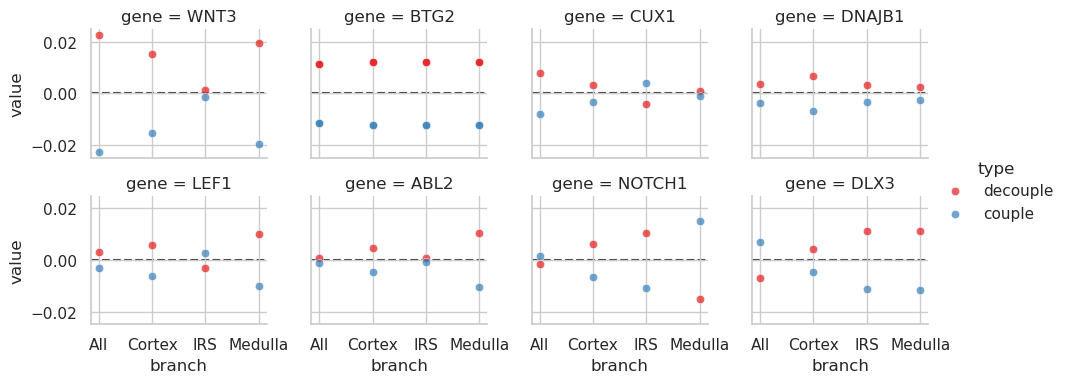

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,4))
# flatui = ["darkgreen", "forestgreen", "limegreen", "palegreen", "darkviolet", "purple", "violet", "plum"]
# sns.set_palette(flatui)
# g = sns.catplot(
#     data=score_df_melt, kind="bar",
#     x="gene", y="value", hue="variable",  alpha=.6, height=10, aspect=3,
# )
# g.despine(left=True)
# g.legend.set_title("")
# plt.xticks(rotation=45)
# plt.show()


g = sns.FacetGrid(score_df_melt, col="gene", col_wrap=4, height=2, aspect =1.2, hue="type", palette="Set1")
g.map(sns.scatterplot, "branch", "value", alpha=.7)
for ax in g.axes_dict.values():
    ax.axline((0, 0), slope=0, c=".2", ls="--", zorder=0,)
g.add_legend()
plt.savefig("hair_gene_peak/gene_level_scores2.png", dpi=300)
# plt.savefig("hair_gene_peak/gene_level_scores.pdf", dpi=300)

# plt.xticks(rotation=45)


In [643]:
# import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go

# plt.figure(figsize=(10,4))

# # for template in ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
# fig = px.line_polar(score_df_melt_all, r="value", theta="variable", color="gene", line_close=True, markers=True,
#                         color_discrete_sequence=px.colors.qualitative.Set3, range_r=[-0.01, 0.02], template="plotly_white")
#     # fig = go.Figure()
# fig.add_trace(go.Scatterpolar(
#                 name="0.0",
#                 mode = "lines",
#                 r = [0]*11,
#                 theta = ["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla","max_couple", "decouple_score"],
#                 line_color = "black",
#                 line_shape = "spline",
#                 hoverinfo = "skip",
#                 showlegend = True))

# fig.write_image("hair_gene_peak/medulla_all_score_polar.pdf")

<Figure size 1000x400 with 0 Axes>

In [107]:
rna_data

AnnData object with n_obs × n_vars = 6436 × 959
    obs: 'atac.bc', 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'model_read_scale', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'latent_time_cat', 'latent_time_2', 'latent_time_10', 'latent_time_3', 'latent_time_8', 'latent_time_6', 'local_peaks', 'temp_gene'
    var: 'feature_types', 'modality', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'hvg', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm

In [79]:
cell_cycle_df = pd.read_csv("hair_gene_peak/GO_term_summary_20240116_095743.txt", sep="\t")
cell_cycle_genes = cell_cycle_df["MGI Gene/Marker ID"].to_list()

In [80]:
cell_cycle_genes = [e.upper() for e in cell_cycle_genes]


In [797]:
path = "hair_gene_peak/couple_genes/"
couple_genes = score_df[score_df["couple score"] > 0].gene
for genename in couple_genes:
    get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X)
    save = path+genename+".jpg"
    smooth_gene_peaks_plot_interv(genename, "latent_time_8",2, points=500, save=save, ticks=False, gcolor="greenyellow", pcolor="darkviolet", title=False)
 

In [81]:
cell_cycle_genes = score_df[score_df.gene.isin(cell_cycle_genes) ].gene.to_list()
print(cell_cycle_genes)



['DCTN1', 'WNT5A', 'BLM', 'CDC25A', 'CENPC1', 'TOPBP1', 'EXOC6B', 'BRD8', 'PTCH1', 'RPTOR', 'INCENP', 'PPP1R12A', 'CPSF3', 'LIG1', 'SDCCAG8', 'MKI67', 'SMPD3', 'CEP164', 'EDNRA', 'SMC2', 'MCM4', 'TXNIP', 'ACVR1B', 'ADARB1', 'AZIN1', 'CTDSP2', 'DAB2IP', 'FGFR1', 'FGFR2', 'FGFR3', 'LEF1', 'MICAL3', 'OVOL1', 'PRKCD', 'SIK1', 'TACC2', 'TRP53BP2']


In [84]:

path = "hair_gene_peak/cellcycle/"
for genename in cell_cycle_genes:
    warnings.filterwarnings('ignore')
    get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X)
    save = path+genename+".jpg"
    try:
        smooth_gene_peaks_plot_interv(genename, time="latent_time_8", rna_data=rna_data, linewidth=1, ticks=True, title=True, gcolor="greenyellow", pcolor="darkviolet",save=save)
    except:
        print(genename)   

BLM
INCENP
SMPD3
FGFR1


In [24]:
cortexrna = rna_data[(rna_data.obs.celltype!="IRS")]
cortexrna = cortexrna[(cortexrna.obs.celltype!="Medulla")]
cortexatac = atac_data[(atac_data.obs.celltype!="IRS")]
cortexatac = cortexatac[(cortexatac.obs.celltype!="Medulla")]
decouple_score_cortex = []
couple_score_cortex = []

irsrna = rna_data[(rna_data.obs.celltype!="Hair Shaft-cuticle.cortex")]
irsrna = irsrna[(irsrna.obs.celltype!="Medulla")]
irsatac = atac_data[(atac_data.obs.celltype!="Hair Shaft-cuticle.cortex")]
irsatac = irsatac[(irsatac.obs.celltype!="Medulla")]
decouple_score_irs = []
couple_score_irs = []

medullarna = rna_data[(rna_data.obs.celltype!="Hair Shaft-cuticle.cortex")]
medullarna = medullarna[(medullarna.obs.celltype!="IRS")]
medullaatac = atac_data[(atac_data.obs.celltype!="Hair Shaft-cuticle.cortex")]
medullaatac = medullaatac[(medullaatac.obs.celltype!="IRS")]

In [92]:
cortexrna = rna_data[(rna_data.obs.celltype!="IRS")]
cortexrna = cortexrna[(cortexrna.obs.celltype!="Medulla")]
cortexatac = atac_data[(atac_data.obs.celltype!="IRS")]
cortexatac = cortexatac[(cortexatac.obs.celltype!="Medulla")]
decouple_score_cortex = []
couple_score_cortex = []

irsrna = rna_data[(rna_data.obs.celltype!="Hair Shaft-cuticle.cortex")]
irsrna = irsrna[(irsrna.obs.celltype!="Medulla")]
irsatac = atac_data[(atac_data.obs.celltype!="Hair Shaft-cuticle.cortex")]
irsatac = irsatac[(irsatac.obs.celltype!="Medulla")]
decouple_score_irs = []
couple_score_irs = []

medullarna = rna_data[(rna_data.obs.celltype!="Hair Shaft-cuticle.cortex")]
medullarna = medullarna[(medullarna.obs.celltype!="IRS")]
medullaatac = atac_data[(atac_data.obs.celltype!="Hair Shaft-cuticle.cortex")]
medullaatac = medullaatac[(medullaatac.obs.celltype!="IRS")]

non_m_rna = rna_data[(rna_data.obs.celltype!="Medulla")]
non_m_atac = atac_data[(atac_data.obs.celltype!="Medulla")]

decouple_score_irs = []
couple_score_irs = []

decouple_score_medulla = []
couple_score_medulla = []

decouple_scores = []
couple_scores = []

# genelist = score_df.gene.to_list()
failed = []
from tqdm import tqdm



In [65]:
genelist = ["WNT3"]

In [70]:
width = 0.1

In [76]:
medullarna

AnnData object with n_obs × n_vars = 4807 × 959
    obs: 'atac.bc', 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'model_read_scale', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'latent_time_cat', 'latent_time_2', 'latent_time_10', 'latent_time_3', 'latent_time_8', 'latent_time_6', 'local_peaks', 'temp_gene'
    var: 'feature_types', 'modality', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'hvg', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm

In [110]:
time = "latent_time"
genelist = ["DNAJB1", "DLX3", "ABL2",  "CUX1", "LEF1", "NOTCH1", "BTG2", "BRAF", "MT1", "KLF6", "GATA3", "WNT3", "RUNX1",  "BTG2", "MICAL3", "AFF3", "HOXC13" , "ATF3"]
# genelist = ["ATF3"]

In [109]:
for i in tqdm(range(len(genelist))):
    genename = genelist[i]
    width= 1e-3
    thresh=1e-5
    try: 

        decouple_score_c, _, _, couple_score_c = gene_level_casual_nonzero(genename,time, litemodel,cortexrna,cortexatac, norm_X=cortexatac.layers["norm"],width=width, thresh=thresh)
        decouple_score_cortex.append(decouple_score_c)
        couple_score_cortex.append(couple_score_c)
        # score_df[score_df.gene==genename]["decouple_cortex"] = decouple_score_c
        # score_df[score_df.gene==genename]["couple_cortex"] = couple_score_c

        decouple_score_i, _, _, couple_score_i = gene_level_casual_nonzero(genename,time, litemodel,irsrna,irsatac, norm_X=irsatac.layers["norm"],width=width, thresh=thresh)
        decouple_score_irs.append(decouple_score_i)
        couple_score_irs.append(couple_score_i)
        # score_df[score_df.gene==genename]["decouple_irs"] = decouple_score_i
        # score_df[score_df.gene==genename]["couple_irs"] = couple_score_i


        decouple_score_m, _, _, couple_score_m = gene_level_casual_nonzero(genename,time, litemodel,medullarna,medullaatac, norm_X=medullaatac.layers["norm"],width=width, thresh=thresh)
        decouple_score_medulla.append(decouple_score_m)
        couple_score_medulla.append(couple_score_m)
        # score_df[score_df.gene==genename]["decouple_medulla"] = decouple_score_m
        # score_df[score_df.gene==genename]["couple_medulla"] = couple_score_m


        decouple_score, _, _, couple_score = gene_level_casual_nonzero(genename,time, litemodel,rna_data,atac_data, norm_X=atac_data.layers["norm"],width=width, thresh=thresh)
        decouple_scores.append(decouple_score)
        couple_scores.append(couple_score)
        # score_df[score_df.gene==genename]["decouple score"] = decouple_score
        # score_df[score_df.gene==genename]["couple score"] = couple_score
    except:
        print(genename)
        failed.append(genename)



100%|██████████| 1/1 [03:45<00:00, 225.41s/it]


ValueError: arrays must all be same length

In [111]:
score_df2 = pd.DataFrame({"gene":genelist, "decouple_score": decouple_scores, "couple_score":couple_scores, 
"decouple_cortex":decouple_score_cortex, "couple_cortex":couple_score_cortex, "decouple_irs":decouple_score_irs, 
"couple_irs":couple_score_irs, "decouple_medulla":decouple_score_medulla, "couple_medulla":couple_score_medulla})
score_df2


,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla
0,DNAJB1,0.003729,-0.003739,0.006927,-0.006937,0.003158,-0.003168,0.002464,-0.002474
1,DLX3,-0.006953,0.006943,0.004440,-0.004450,0.011172,-0.011182,0.011416,-0.011426
2,ABL2,0.000944,-0.000954,0.004690,-0.004700,0.000842,-0.000852,0.010440,-0.010450
3,CUX1,0.007779,-0.007789,0.003132,-0.003142,-0.004232,0.004222,0.000837,-0.000847
4,LEF1,0.003026,-0.003036,0.006024,-0.006034,-0.002923,0.002913,0.009945,-0.009955
5,NOTCH1,-0.001618,0.001608,0.006366,-0.006376,0.010606,-0.010616,-0.014981,0.014971
6,BTG2,0.011571,-0.011581,0.012203,-0.012213,0.012174,-0.012184,0.012286,-0.012296
7,BRAF,0.007733,-0.007743,0.007390,-0.007400,0.010632,-0.010642,0.010857,-0.010867
8,MT1,0.012496,-0.012506,0.012104,-0.012114,0.012282,-0.012292,0.012571,-0.012581
9,KLF6,0.002708,-0.002718,0.005781,-0.005791,0.000837,-0.000847,-0.001727,0.001717


In [119]:
score_df2.to_csv("hair_gene_peak/gene_score_picked.csv")

In [78]:
decouple_score_m, _, _, couple_score_m = gene_level_casual_nonzero(genename,time, litemodel,medullarna,medullaatac, norm_X=medullaatac.layers["norm"],width=width, thresh=1e-5)
print(decouple_score_m, couple_score_m)

0.019700617560730348 -0.019710617560730347


In [22]:
score_df2.to_csv("hair_gene_peak/score_full_001.csv")

In [24]:
score_df = pd.read_csv("hair_gene_peak/score_full.csv")
score_df[["gene", "super_enhancer"]]

,gene,super_enhancer
0,ENOX1,False
1,DCTN1,False
2,MAGI1,False
3,FBRSL1,False
4,KIF15,False
...,...,...
270,TRP53BP2,True
271,VGLL4,True
272,ZFAND5,True
273,ZFP750,True


In [421]:
score_df.to_csv("hair_gene_peak/score_full_updated.csv")

In [25]:
score_df2 = pd.merge(left = score_df2, right=score_df[["gene", "super_enhancer"]], on="gene")
score_df2

,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,super_enhancer
0,ENOX1,-0.010385,0.010375,0.000415,-0.000425,-0.008803,0.008793,-0.009288,0.009278,False
1,DCTN1,0.000782,-0.000792,0.002949,-0.002959,-0.008502,0.008492,-0.005527,0.005517,False
2,MAGI1,0.001516,-0.001526,0.005577,-0.005587,-0.002761,0.002751,0.000357,-0.000367,False
3,FBRSL1,-0.006040,0.006030,-0.002949,0.002939,-0.008857,0.008847,-0.014170,0.014160,False
4,KIF15,0.005116,-0.005126,0.019120,-0.019130,0.009126,-0.009136,0.012663,-0.012673,False
...,...,...,...,...,...,...,...,...,...,...
270,TRP53BP2,-0.009342,0.009332,0.008785,-0.008795,-0.003960,0.003950,0.012646,-0.012656,True
271,VGLL4,-0.008721,0.008711,-0.002690,0.002680,-0.003377,0.003367,-0.000960,0.000950,True
272,ZFAND5,-0.003675,0.003665,-0.008324,0.008314,-0.009355,0.009345,-0.017097,0.017087,True
273,ZFP750,-0.000437,0.000427,0.011929,-0.011939,0.003937,-0.003947,0.003308,-0.003318,True


In [27]:
score_df2[score_df2.gene=="DLX3"]

,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,super_enhancer
180,DLX3,-0.005524,0.005514,-0.013791,0.013781,-0.009851,0.009841,-0.010812,0.010802,True


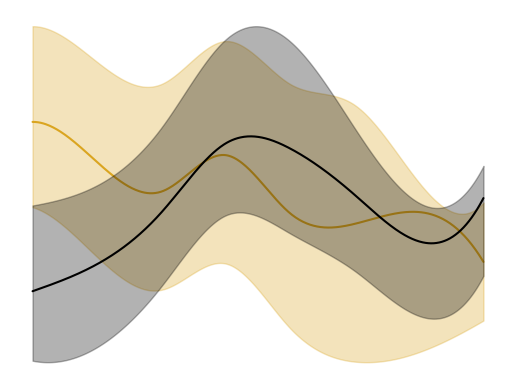

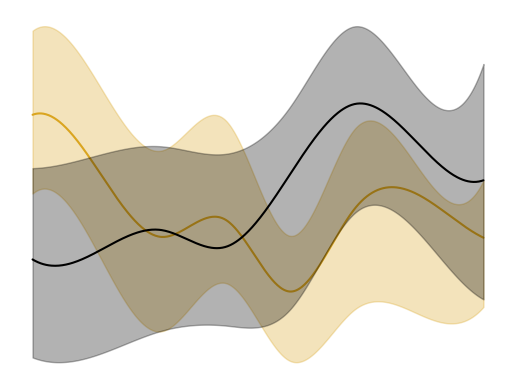

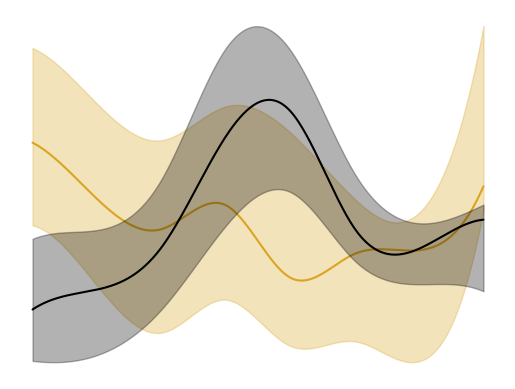

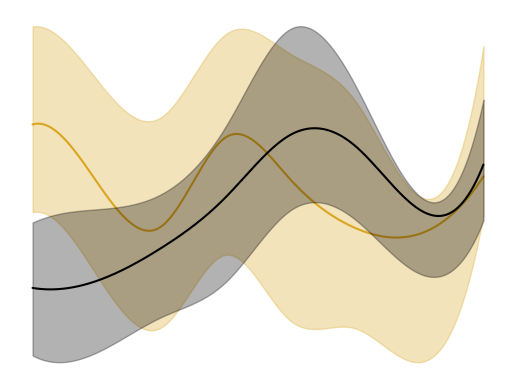

In [114]:
genename = "MAP7"
genename = genename.upper()
get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X=atac_data.layers["norm"])
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= rna_data,linewidth = 2, points=500, pcolor="black", gcolor="goldenrod")

get_gene_local_atac(genename, litemodel, irsrna, irsatac, norm_X=irsatac.layers["norm"])
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= irsrna,linewidth = 2, points=500, pcolor="black", gcolor="goldenrod")

get_gene_local_atac(genename, litemodel, cortexrna, cortexatac, norm_X=cortexatac.layers["norm"])
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= cortexrna,linewidth = 2, points=500, pcolor="black", gcolor="goldenrod")

get_gene_local_atac(genename, litemodel, medullarna, medullaatac, norm_X=medullaatac.layers["norm"])
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= medullarna,linewidth = 2, points=500, pcolor="black", gcolor="goldenrod")

In [84]:
genename = "WNT3"
genename = genename.upper()
get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X=atac_data.layers["norm"])
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= rna_data,linewidth = 2, points=500, gcolor="greenyellow", pcolor="darkviolet", save="hair_gene_peak/all/"+genename+".png", gquant=0.95)
# smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= irsrna,linewidth = 2, points=500, gcolor="greenyellow", pcolor="darkviolet", gquant=0.95)

latent_time_8
0    3.816491
1    3.690448
2    3.874744
3    3.790994
4    3.634961
5    3.898110
6    3.529666
7    3.926936
Name: temp_gene, dtype: float32
latent_time_8
0    0.000029
1    0.000026
2    0.000023
3    0.000028
4    0.000023
5    0.000019
6    0.000016
7    0.000015
Name: local_peaks, dtype: float32


latent_time_8
0    3.816491
1    4.046216
2    3.603166
3    3.787740
4    2.672567
5    0.000000
6    3.529666
7    3.926936
Name: temp_gene, dtype: float32
latent_time_8
0    0.000025
1    0.000021
2    0.000015
3    0.000015
4    0.000016
5    0.000017
6    0.000016
7    0.000015
Name: local_peaks, dtype: float32
latent_time_8
0    3.816491
1    4.046216
2    3.603166
3    3.787740
4    2.672567
5    0.000000
6    3.529666
7    3.926936
Name: temp_gene, dtype: float32
latent_time_8
0    0.000025
1    0.000021
2    0.000015
3    0.000015
4    0.000016
5    0.000017
6    0.000016
7    0.000015
Name: local_peaks, dtype: float32
latent_time_8
0    3.791097
1    3.769834
2    3.691059
3    3.944159
4    3.807837
5    2.974885
6    0.000000
7    3.926936
Name: temp_gene, dtype: float32
latent_time_8
0    0.000029
1    0.000025
2    0.000023
3    0.000031
4    0.000027
5    0.000021
6    0.000021
7    0.000021
Name: local_peaks, dtype: float32
latent_time_8
0    3.791097
1    3.769834
2   

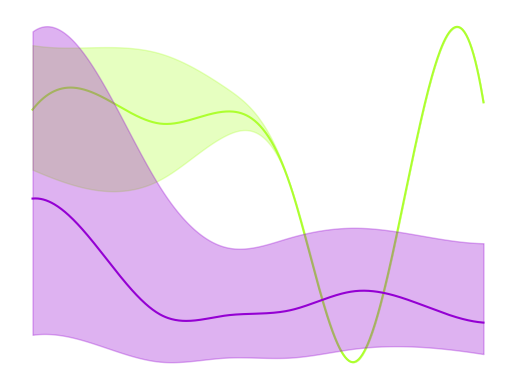

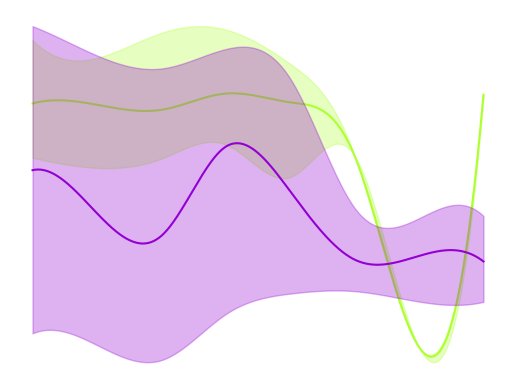

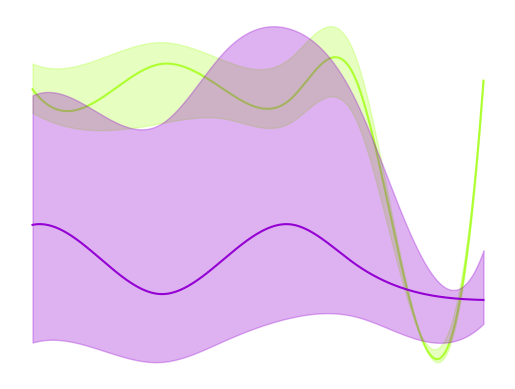

In [71]:
genename = "WNT3"
get_gene_local_atac(genename, litemodel,irsrna, irsatac, norm_X=irsatac.layers["norm"])
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= irsrna,linewidth = 2, points=500, gcolor="greenyellow", pcolor="darkviolet", gquant=0.95, pquant=0.8)
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= irsrna,linewidth = 2, points=500, gcolor="greenyellow", pcolor="darkviolet", gquant=0.8, pquant=0.8, save="hair_gene_peak/IRS/"+genename+".png")
get_gene_local_atac(genename, litemodel,cortexrna, cortexatac, norm_X=cortexatac.layers["norm"])
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= cortexrna,linewidth = 2, points=500, gcolor="greenyellow", pcolor="darkviolet", gquant=0.8, pquant=0.8, save="hair_gene_peak/cortex/"+genename+".png")
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= cortexrna,linewidth = 2, points=500, gcolor="greenyellow", pcolor="darkviolet", gquant=0.95, pquant=0.8)

get_gene_local_atac(genename, litemodel,medullarna, medullaatac, norm_X=medullaatac.layers["norm"])

smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= medullarna,linewidth = 2, points=500, gcolor="greenyellow", pcolor="darkviolet", gquant=0.8, pquant=0.8, save="hair_gene_peak/medulla/"+genename+".png")
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= medullarna,linewidth = 2, points=500, gcolor="greenyellow", pcolor="darkviolet", gquant=0.8, pquant=0.8)

In [52]:
get_gene_local_atac(genename, litemodel,irsrna, irsatac, norm_X=irsatac.layers["norm"])
irsrna.obs["local_peaks"]

0_paired       0.000012
1_paired       0.000012
2_paired       0.000029
3_paired       0.000009
4_paired       0.000014
                 ...   
5433_paired    0.000039
5434_paired    0.000026
5435_paired    0.000029
5436_paired    0.000035
5437_paired    0.000023
Name: local_peaks, Length: 4626, dtype: float32

In [28]:
TFs = []
with open("mouse_tf.txt") as f:
     for line in f:
        # Check if the line starts with ">MA"
        if line.startswith('>MA'):
            # Process the line (for now, just print it)
            line_list = line.strip().split('\t')
            gene = line_list[1]
            gene = gene.upper()
            TFs.append(gene)
TFs = pd.DataFrame({"TF":TFs})
TFs.to_csv("mouse_TFs.csv")

IndexError: list index out of range

In [558]:
genename = "KLF6"
genename = genename.upper()
get_gene_local_atac(genename, litemodel, irsrna, irsatac, norm_X=irsatac.layers["norm"])
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= irsrna,linewidth = 2, points=500, pcolor="black", gcolor="goldenrod"), 

['KLF6']

In [521]:
genes = ["NTN1"]
for genename in genes:
    # smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=irsrna, atac_data=irsatac, norm_X = irsatac.layers["norm"],
    # linewidth=1, gcolor="greenyellow", pcolor="darkviolet", save="hair_gene_peak/IRS/marker/"+genename+".jpg")
    get_gene_local_atac(genename, litemodel, irsrna, irsatac, norm_X=irsatac.layers["norm"])
    smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= irsrna,linewidth = 2, points=500,gcolor="greenyellow", pcolor="darkviolet", save="hair_gene_peak/IRS/marker/"+genename+".jpg"),

In [682]:
gene_level_casual_nonzero("LEF1","latent_time_8", litemodel,cortexrna, cortexatac, norm_X=cortexatac.layers["norm"],width=0.001, thresh=1e-5)

(0.0006065622661518694,
 0.038648681115910646,
 0.039255243382062516,
 -0.0006165622661518694)

In [539]:
gene_level_casual("SREBF2","latent_time_10", litemodel,irsrna, irsatac, norm_X=irsatac.layers["norm"],width=0.1)


(0.001775962076826735, 0.025123612491715398, 0.023347650414888663)

In [427]:
score_df.to_csv("hair_gene_peak/score_full_updated.csv")

In [256]:
se_gene = pd.read_csv("hair_gene_peak/score_full.csv")
genelist = se_gene[se_gene.super_enhancer==True].gene.to_list()
path = "hair_gene_peak/super_enhancer/IRS/"
for genename in genelist:
    warnings.filterwarnings('ignore')
    smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=irsrna, atac_data=irsatac, norm_X = irsatac.layers["norm"],
        linewidth=1, ticks=False, title=False, gcolor="greenyellow", pcolor="darkviolet", save=path+genename+".jpg")

In [257]:
se_gene = pd.read_csv("hair_gene_peak/score_full.csv")
genelist = se_gene[se_gene.super_enhancer==True].gene.to_list()
path = "hair_gene_peak/super_enhancer/medulla/"
for genename in genelist:
    warnings.filterwarnings('ignore')
    smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=medullarna, atac_data=medullaatac, norm_X = medullaatac.layers["norm"],
        linewidth=1, ticks=False, title=False, gcolor="greenyellow", pcolor="darkviolet", save=path+genename+".jpg")

In [258]:
se_gene = pd.read_csv("hair_gene_peak/score_full.csv")
genelist = se_gene[se_gene.super_enhancer==True].gene.to_list()
path = "hair_gene_peak/super_enhancer/cortex/"
for genename in genelist:
    warnings.filterwarnings('ignore')
    smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=cortexrna, atac_data=cortexatac, norm_X = cortexatac.layers["norm"],
        linewidth=1, ticks=False, title=False, gcolor="greenyellow", pcolor="darkviolet", save=path+genename+".jpg")

In [255]:
se_gene = pd.read_csv("hair_gene_peak/score_full.csv")
genelist = se_gene[se_gene.super_enhancer==True].gene.to_list()
path = "hair_gene_peak/super_enhancer/all/"
for genename in genelist:
    warnings.filterwarnings('ignore')
    smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=rna_data, atac_data=atac_data, norm_X = atac_data.layers["norm"],
        linewidth=1, ticks=False, title=False, gcolor="greenyellow", pcolor="darkviolet", save=path+genename+".jpg")

In [38]:
score_df = score_df2[score_df2.super_enhancer==True]
score_df["max_decouple"] =  score_df[['decouple_score', 'decouple_medulla', 'decouple_cortex', "decouple_irs"]].max(axis=1)
score_df["max_couple"] =  score_df[['couple_score', 'couple_medulla', 'couple_cortex', "couple_irs"]].max(axis=1)
score_df_melt = pd.melt(score_df, id_vars=["gene"], 
value_vars=["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla","max_couple"])
score_df_melt

,gene,variable,value
0,ABL2,decouple_score,-0.005697
1,ACVR1B,decouple_score,0.001309
2,ADARB1,decouple_score,-0.003166
3,AFF3,decouple_score,0.003459
4,AGPAT3,decouple_score,-0.003275
...,...,...,...
1165,TRP53BP2,max_couple,0.009332
1166,VGLL4,max_couple,0.008711
1167,ZFAND5,max_couple,0.017087
1168,ZFP750,max_couple,0.000427


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'decouple_score'),
  Text(1, 0, 'decouple_cortex'),
  Text(2, 0, 'decouple_irs'),
  Text(3, 0, 'decouple_medulla'),
  Text(4, 0, 'max_decouple'),
  Text(5, 0, 'couple_score'),
  Text(6, 0, 'couple_cortex'),
  Text(7, 0, 'couple_irs'),
  Text(8, 0, 'couple_medulla'),
  Text(9, 0, 'max_couple')])

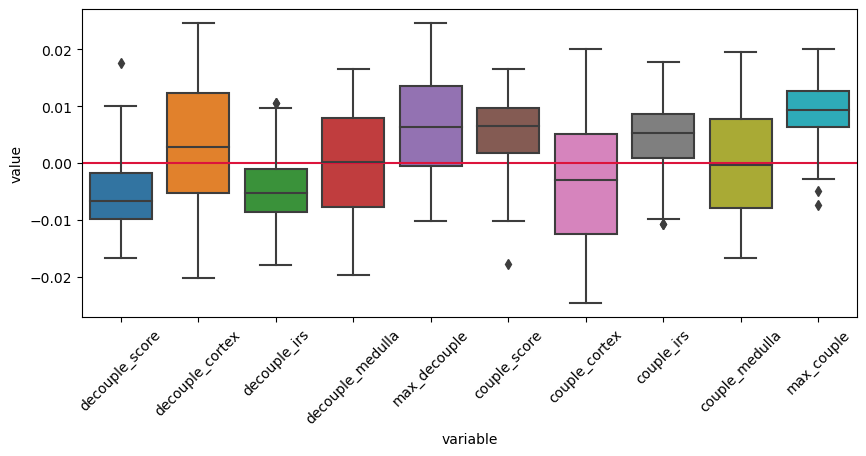

In [39]:
import seaborn as sns
plt.figure(figsize=(10,4))
plt.axhline(y=0.0, color='crimson') 
sns.boxplot(data=score_df_melt, x="variable", y="value")
plt.xticks(rotation=45)

In [113]:
score_df2 = pd.DataFrame({"gene":score_df.gene, "couple_score": couple_scores, "decouple_score": decouple_scores, "decouple_irs":decouple_score_irs, 
                        "couple_irs":couple_score_irs, "decouple_cortex":decouple_score_cortex, "couple_cortex":couple_score_cortex, 
                        "decouple_medulla":decouple_score_medulla, "couple_medulla":couple_score_medulla})
score_df2                        

,gene,couple_score,decouple_score,decouple_irs,couple_irs,decouple_cortex,couple_cortex,decouple_medulla,couple_medulla
0,ENOX1,-0.005306,0.005296,-0.006117,0.006107,0.005971,-0.005981,-0.001292,0.001282
1,DCTN1,-0.002297,0.002287,-0.001700,0.001690,-0.000512,0.000502,0.001317,-0.001327
2,MAGI1,0.016544,-0.016554,-0.001090,0.001080,-0.007149,0.007139,0.003968,-0.003978
3,FBRSL1,-0.000407,0.000397,0.006046,-0.006056,0.001441,-0.001451,0.009925,-0.009935
4,KIF15,-0.001201,0.001191,-0.000779,0.000769,0.001461,-0.001471,0.002616,-0.002626
...,...,...,...,...,...,...,...,...,...
112,TRP53BP2,-0.004417,0.004407,0.006183,-0.006193,0.004001,-0.004011,-0.003781,0.003771
113,VGLL4,-0.000667,0.000657,0.006380,-0.006390,0.004686,-0.004696,0.004370,-0.004380
114,ZFAND5,0.002957,-0.002967,-0.001430,0.001420,0.001426,-0.001436,0.001910,-0.001920
115,ZFP750,-0.014534,0.014524,0.016083,-0.016093,0.007929,-0.007939,0.001610,-0.001620


In [114]:
score_df2["max_decouple"] =  score_df2[['decouple_score', 'decouple_medulla', 'decouple_cortex', "decouple_irs"]].max(axis=1)
score_df2["max_couple"] =  score_df2[['couple_score', 'couple_medulla', 'couple_cortex', "couple_irs"]].max(axis=1)
score_df_melt2 = pd.melt(score_df2, id_vars=["gene"], 
value_vars=["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla","max_couple"])
score_df_melt2

,gene,variable,value
0,ENOX1,decouple_score,0.005296
1,DCTN1,decouple_score,0.002287
2,MAGI1,decouple_score,-0.016554
3,FBRSL1,decouple_score,0.000397
4,KIF15,decouple_score,0.001191
...,...,...,...
2745,TRP53BP2,max_couple,0.003771
2746,VGLL4,max_couple,-0.000667
2747,ZFAND5,max_couple,0.002957
2748,ZFP750,max_couple,-0.001620


In [116]:
score_df2.to_csv("hair_gene_peak/score_full_new.csv")

In [430]:
score_en = score_df[score_df.super_enhancer==True]
score_en_melt = pd.melt(score_en, id_vars=["gene"], 
value_vars=["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla","max_couple"])
score_en_melt


,gene,variable,value
0,ABL2,decouple_score,0.015079
1,ACVR1B,decouple_score,-0.004606
2,ADARB1,decouple_score,-0.002629
3,AFF3,decouple_score,-0.000649
4,AGPAT3,decouple_score,0.000335
...,...,...,...
1165,TRP53BP2,max_couple,0.001860
1166,VGLL4,max_couple,0.008362
1167,ZFAND5,max_couple,0.000290
1168,ZFP750,max_couple,-0.000332


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'decouple_score'),
  Text(1, 0, 'decouple_cortex'),
  Text(2, 0, 'decouple_irs'),
  Text(3, 0, 'decouple_medulla'),
  Text(4, 0, 'max_decouple'),
  Text(5, 0, 'couple_score'),
  Text(6, 0, 'couple_cortex'),
  Text(7, 0, 'couple_irs'),
  Text(8, 0, 'couple_medulla'),
  Text(9, 0, 'max_couple')])

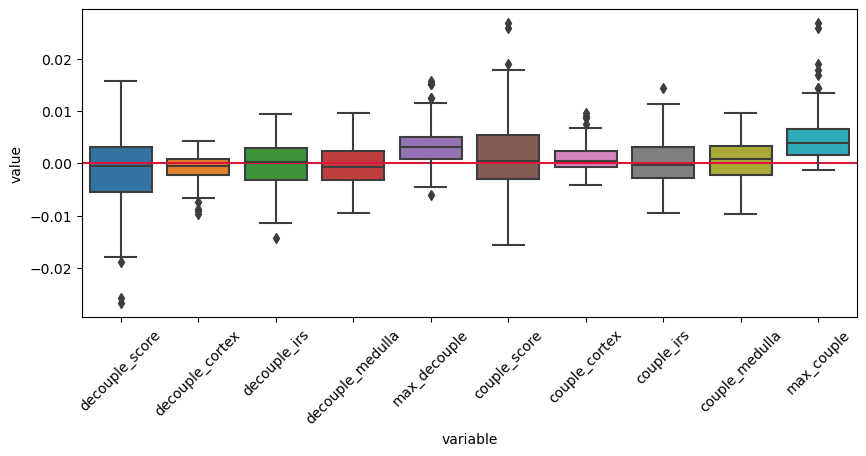

In [431]:
plt.figure(figsize=(10,4))
plt.axhline(y=0.0, color='crimson') 
sns.boxplot(data=score_en_melt, x="variable", y="value")
plt.xticks(rotation=45)

In [711]:
# plt.figure(figsize=(10,4))

# # for template in ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
# fig = px.line_polar(score_cc_melt, r="value", theta="variable", color="gene", line_close=True, markers=True,
#                         color_discrete_sequence=px.colors.qualitative.Set3, range_r=[-0.01, 0.02], template="plotly_white")
#     # fig = go.Figure()
# fig.add_trace(go.Scatterpolar(
#                 name="0.0",
#                 mode = "lines",
#                 r = [0]*11,
#                 theta = ["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla","max_couple", "decouple_score"],
#                 line_color = "black",
#                 line_shape = "spline",
#                 hoverinfo = "skip",
#                 showlegend = True))

# fig.write_image("hair_gene_peak/cortex_decouple_score_polar.pdf")

<Figure size 1000x400 with 0 Axes>

In [131]:
score_df[score_df.gene.isin(["BLM", "FGFR1", "SIK1", "BTG2", "DLX3", "DNAJB1", "NOTCH1", "MYO18A", "ABL2"])]

,gene,decouple score,couple score,decouple_irs,couple_irs,decouple_medulla,couple_medulla,decouple_cortex,couple_cortex,super_enhancer,max_decouple,max_couple
18,BLM,0.003275,-0.003285,0.000936,-0.001936,0.000989,-0.000999,0.001140,-0.001150,False,0.003275,-0.000999
0,ABL2,0.012185,-0.012195,0.002398,-0.002408,0.002398,-0.002408,-0.001876,0.001866,True,0.012185,0.001866
11,BTG2,0.002733,-0.002743,0.005464,-0.005474,0.005464,-0.005474,-0.007845,0.007835,True,0.005464,0.007835
22,DLX3,0.009419,-0.009429,0.005957,-0.005967,0.005957,-0.005967,-0.001332,0.001322,True,0.009419,0.001322
23,DNAJB1,0.012668,-0.012678,0.002335,-0.002345,0.002335,-0.002345,0.000612,-0.000622,True,0.012668,-0.000622
29,FGFR1,-0.001705,0.001695,0.004405,-0.004415,0.004405,-0.004415,0.001708,-0.001718,True,0.004405,0.001695
68,MYO18A,0.002243,-0.002253,0.001700,-0.001710,0.001700,-0.001710,0.002868,-0.002878,True,0.002868,-0.001710
72,NOTCH1,0.002210,-0.002220,0.000601,-0.000611,0.000601,-0.000611,-0.002951,0.002941,True,0.002210,0.002941
96,SIK1,0.010228,-0.010238,0.005319,-0.005329,0.005319,-0.005329,0.001591,-0.001601,True,0.010228,-0.001601


In [71]:
irs_df = score_df[(score_df['decouple score']<0) & (score_df['decouple_irs']>0)].sort_values("decouple_irs", ascending=False)

In [111]:
irs_df.to_csv("hair_gene_peak/IRS_decouple.csv")

In [101]:
import warnings
path = "hair_gene_peak/IRS/marker/"
for genename in ["MT2", "CTSC", "KRT71", "KRT28", "TCHH", "BAMBI"]:
    warnings.filterwarnings('ignore')
    save = path+genename+".jpg"
    try:
        get_gene_local_atac(genename, litemodel, irsrna, irsatac, norm_X=irsatac.layers["norm"])

        smooth_gene_peaks_plot_interv(genename, time="latent_time_8", rna_data=irsrna, linewidth=1, ticks=True, title=True, gcolor="greenyellow", pcolor="darkviolet",save=save)
    except:
        print(genename)   

In [110]:
import warnings
path = "hair_gene_peak/IRS/marker/TF/"
for genename in ["CUX1", "GRHL1", "GATA3", "MAF"]:
    warnings.filterwarnings('ignore')
    save = path+genename+".jpg"
    try:
        get_gene_local_atac(genename, litemodel, irsrna, irsatac, norm_X=irsatac.layers["norm"])

        smooth_gene_peaks_plot_interv(genename, time="latent_time_8", rna_data=irsrna, linewidth=1, ticks=True, title=True, gcolor="greenyellow", pcolor="darkviolet",save=save)
    except:
        print(genename)   

In [309]:
[e for e in rna_data.var.index if "KITL" in e]

['KITL']

In [340]:
path="hair_gene_peak/super_enhancer/decouple/"
genename = "LEF1"
smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=rna_data, atac_data=atac_data, norm_X = atac_data.layers["norm"],
linewidth=1, ticks=True, title=True, gcolor="greenyellow", pcolor="darkviolet", save=path+genename+".jpg")

In [723]:
genelist = ["PTCH2"]
decouple_score_cortex=[]
couple_score_cortex = []
decouple_score_irs = []
couple_score_irs = []
decouple_score_medulla = []
couple_score_medulla = []
decouple_scores = []
couple_scores = []
time="latent_time"
width=1e-3
for i in tqdm(range(len(genelist))):
    genename = genelist[i]
    try: 

        decouple_score_c, _, _, couple_score_c = gene_level_casual_nonzero(genename,time, litemodel,cortexrna,cortexatac, norm_X=cortexatac.layers["norm"],width=width, thresh=1e-5)
        decouple_score_cortex.append(decouple_score_c)
        couple_score_cortex.append(couple_score_c)

        decouple_score_i, _, _, couple_score_i = gene_level_casual_nonzero(genename,time, litemodel,irsrna,irsatac, norm_X=irsatac.layers["norm"],width=width, thresh=1e-5)
        decouple_score_irs.append(decouple_score_i)
        couple_score_irs.append(couple_score_i)


        decouple_score_m, _, _, couple_score_m = gene_level_casual_nonzero(genename,time, litemodel,medullarna,medullaatac, norm_X=medullaatac.layers["norm"],width=width, thresh=1e-5)
        decouple_score_medulla.append(decouple_score_m)
        couple_score_medulla.append(couple_score_m)



        decouple_score, _, _, couple_score = gene_level_casual_nonzero(genename,time, litemodel,rna_data,atac_data, norm_X=atac_data.layers["norm"],width=width, thresh=1e-5)
        decouple_scores.append(decouple_score)
        couple_scores.append(couple_score)

    except:
        print(genename)
        failed.append(genename)

100%|██████████| 1/1 [03:31<00:00, 211.62s/it]


In [724]:
score_add = pd.DataFrame({"gene":genelist, "decouple_score": decouple_scores, "couple_score":couple_scores, 
"decouple_cortex":decouple_score_cortex, "couple_cortex":couple_score_cortex, "decouple_irs":decouple_score_irs, 
"couple_irs":couple_score_irs, "decouple_medulla":decouple_score_medulla, "couple_medula":couple_score_medulla})
score_add

,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medula
0,PTCH2,-0.002104,0.002094,-0.000611,0.000601,0.000068,-0.000078,-0.000373,0.000363


In [603]:
score_add["decouple_score"] = -score_add["decouple_score"]
score_add["couple_score"] = -score_add["couple_score"]
score_add["decouple_cortex"] = -score_add["decouple_cortex"]
score_add["couple_cortex"] = -score_add["couple_cortex"]
score_add["decouple_irs"] = -score_add["decouple_irs"]
score_add["couple_irs"] = -score_add["couple_irs"]
score_add["decouple_medulla"] = -score_add["decouple_medulla"]
score_add["couple_medula"] = -score_add["couple_medula"]
score_add


,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medula
0,CTSC,0.004216,-0.004206,0.000972,-0.000962,0.010803,-0.010793,0.006979,-0.006969


In [707]:
score_df = score_df.append(score_add)

In [365]:
gene_level_casual_nonzero("HTRA1","latent_time", litemodel,rna_data,atac_data, norm_X=atac_data.layers["norm"],width=0.1, thresh=1e-5)

(0.0006315830466405298,
 0.07283016416685328,
 0.07346174721349381,
 -0.0006415830466405298)

In [118]:
genename = "PTCH2"
decouple_score, _, _, couple_score = gene_level_casual_nonzero(genename,time, litemodel,rna_data,atac_data, norm_X=atac_data.layers["norm"],width=0.1, thresh=1e-5)
print(decouple_score, couple_score)
decouple_score_c, _, _, couple_score_c = gene_level_casual_nonzero(genename,time, litemodel,cortexrna,cortexatac, norm_X=cortexatac.layers["norm"],width=0.1, thresh=1e-5)
print(decouple_score_c, couple_score_c)
decouple_score_i, _, _, couple_score_i = gene_level_casual_nonzero(genename,time, litemodel,irsrna,irsatac, norm_X=irsatac.layers["norm"],width=0.1, thresh=1e-5)
print(decouple_score_i, couple_score_i)
decouple_score_m, _, _, couple_score_m = gene_level_casual_nonzero(genename,time, litemodel,medullarna,medullaatac, norm_X=medullaatac.layers["norm"],width=0.1, thresh=1e-5)
print(decouple_score_m, couple_score_m)

0.003486840857034379 -0.003496840857034379
-0.004016099013466265 0.004006099013466265
-0.007003364734533557 0.006993364734533557
-0.00354126465085107 0.0035312646508510698
